In [12]:
# Function:
# 	提取时域特征
def TFeatures(x):
    # 均值
    mean = x.mean()
    # 标准差
    std = x.var() ** 0.5
    # 偏态
    skewness = ((x - mean) ** 3).mean() / std ** 3
    # 峰态
    kurtosis = ((x - mean) ** 4).mean() / std ** 4
    return [mean, std, skewness, kurtosis]


# Function:
# 	提取频域特征
def FFeatures(x):
    x = np.array(x)
    x = x.reshape(-1, 5).mean(1)
    fft = np.fft.fft(x)
    fft = fft[2: (fft.size // 2 + 1)]
    fft = abs(fft)
    power = fft.sum()
    fft = np.array_split(fft, 10)
    return [i.sum() / power for i in fft]


# Function:
# 	计算每个音乐文件的特征
def ComputeFeatures(x):
    x = np.array(x)
    fv = []
    # Part1
    xs = x
    diff = xs[1:] - xs[:-1]
    fv.extend(TFeatures(xs))
    fv.extend(TFeatures(diff))
    # Part2
    xs = x.reshape(-1, 10).mean(1)
    diff = xs[1:] - xs[:-1]
    fv.extend(TFeatures(xs))
    fv.extend(TFeatures(diff))
    # Part3
    xs = x.reshape(-1, 100).mean(1)
    diff = xs[1:] - xs[:-1]
    fv.extend(TFeatures(xs))
    fv.extend(TFeatures(diff))
    # Part4
    xs = x.reshape(-1, 1000).mean(1)
    diff = xs[1:] - xs[:-1]
    fv.extend(TFeatures(xs))
    fv.extend(TFeatures(diff))
    # Part5
    fv.extend(FFeatures(x))
    return fv

In [13]:


# 假设所有音频文件都放在名为 'genres' 的文件夹中，该文件夹包含子文件夹，每个子文件夹代表一个流派
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
data = []
labels = []

import numpy as np
import librosa
import os
from tqdm import tqdm 

# 初始化数据和标签列表
data = []
labels = []

for genre in genres:
    genre_folder = f'./genres/{genre}'
    # 获取目录下的文件列表，并初始化一个tqdm进度条
    files = os.listdir(genre_folder)
    for filename in tqdm(files, desc=f'Processing {genre} genre'):
        song_path = os.path.join(genre_folder, filename)
        try:
            y, sr = librosa.load(song_path, mono=True, duration=30)
             # 应用预处理：平滑滤波
            y_filtered = librosa.effects.preemphasis(y)
    
            # 时域特征提取
            rms = np.mean(librosa.feature.rms(y=y_filtered))
            zcr = np.mean(librosa.feature.zero_crossing_rate(y_filtered))
            autocorr = np.mean(librosa.autocorrelate(y_filtered))
    
            # 频域特征提取
            spectral_centroids = np.mean(librosa.feature.spectral_centroid(y=y_filtered, sr=sr))
            spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y_filtered, sr=sr))
            spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y_filtered, sr=sr))
    
            # MFCCs
            mfccs = librosa.feature.mfcc(y=y_filtered, sr=sr, n_mfcc=13)
            mfccs_processed = np.mean(mfccs.T, axis=0)
    
            # 差分特征
            delta_mfccs = librosa.feature.delta(mfccs)
            delta2_mfccs = librosa.feature.delta(mfccs, order=2)
            delta_mfccs_processed = np.mean(delta_mfccs.T, axis=0)
            delta2_mfccs_processed = np.mean(delta2_mfccs.T, axis=0)
    
            # FFT 特征
            fft_features = np.abs(np.fft.rfft(y_filtered)[:1000])
    
            # 组合所有特征
            features = np.hstack([rms, zcr, autocorr, spectral_centroids, spectral_rolloff, spectral_contrast, mfccs_processed, delta_mfccs_processed, delta2_mfccs_processed, fft_features])
    
            data.append(features)
            labels.append(genre)

        
        except Exception as e:
            print(f"Error processing {song_path}: {e}")
            continue  # 发生异常时跳过当前文件，继续处理下一个文件


data = np.array(data)
labels = np.array(labels)
print(data.shape)
print(labels.shape)

Processing jazz genre:  54%|█████▍    | 54/100 [00:31<00:26,  1.72it/s]C:\Users\Akagi\AppData\Local\Temp\ipykernel_38616\1362972713.py:22: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(song_path, mono=True, duration=30)
C:\Users\Akagi\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing ./genres/jazz\jazz.00054.wav: 


Processing rock genre: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]

(999, 1045)
(999,)


In [14]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from sklearn.cluster import KMeans
# from sklearn.pipeline import make_pipeline
# import numpy as np
# 
# # 假设 data 是我们之前从音频文件中提取的特征数据
# 
# # 数据标准化
# scaler = StandardScaler()
# data_scaled = scaler.fit_transform(data)
# 
# # PCA 降维
# # 选择主成分数量以解释至少 95% 的方差
# pca = PCA(n_components=0.95)
# 
# # KMeans 聚类
# kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)  # 使用多次初始化以寻找最佳聚类结果
# 
# # 创建一个管道，将标准化、PCA 和 k-means 联结起来
# pipeline = make_pipeline(scaler, pca, kmeans)
# 
# # 拟合模型
# pipeline.fit(data)
# 
# # 获取聚类标签
# labels = pipeline.predict(data)
# 
# # PCA 降维后的数据可以用于进一步分析或可视化
# pca_features = pipeline.named_steps['pca'].transform(data_scaled)
# 
# # 输出每个类别的样本数
# unique_labels, counts = np.unique(labels, return_counts=True)
# for label, count in zip(unique_labels, counts):
#     print(f"Cluster {label}: {count} samples")


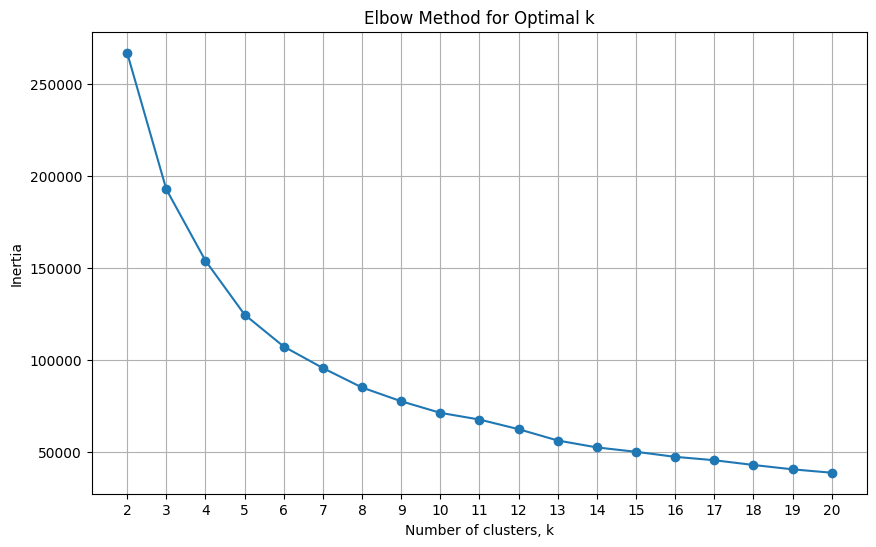

In [15]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np

# 假设 `data` 是我们之前从音频文件中提取的特征数据

# 数据标准化
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# 为了加快计算，可以先将数据降维（这一步是可选的）
pca = PCA(n_components=3)
data_pca = pca.fit_transform(data_scaled)

# 测试的 k 值范围
k_values = range(2, 21)
inertias = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(data_pca)
    inertias.append(kmeans.inertia_)

# 绘制肘部图
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertias, '-o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)
plt.show()

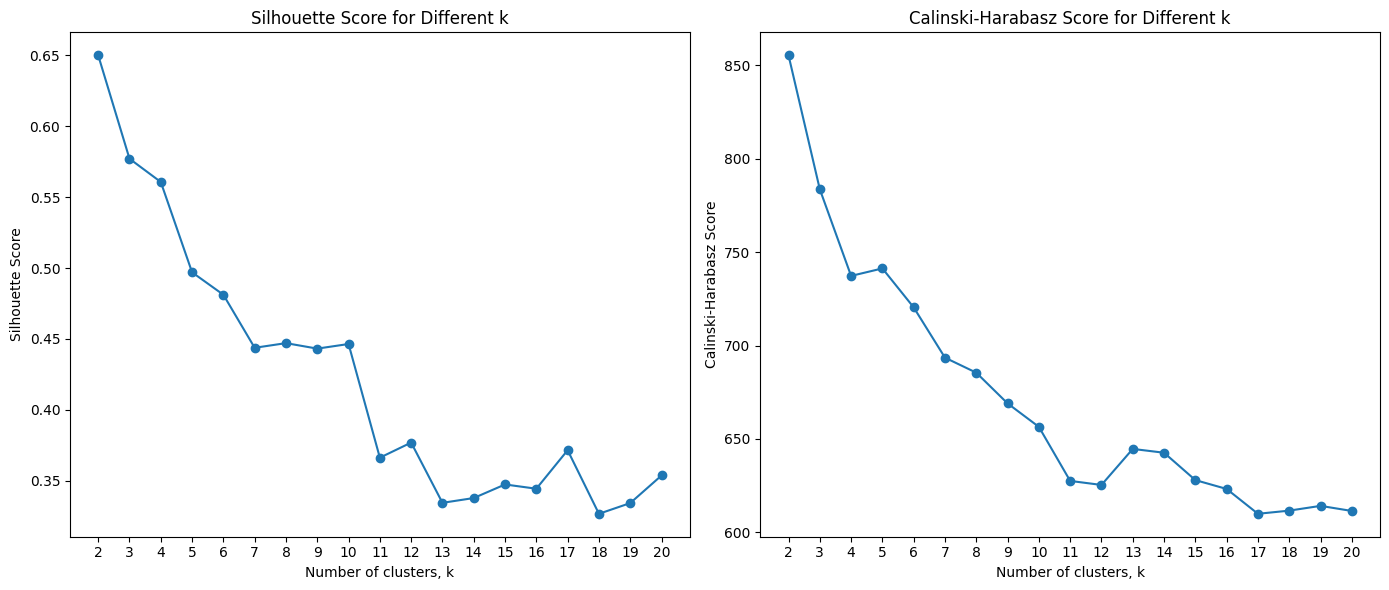

In [16]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# 之前已经定义的变量：data_pca, k_values
silhouette_scores = []
calinski_harabasz_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(data_pca)
    
    # 轮廓系数
    silhouette_avg = silhouette_score(data_pca, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    
    # Calinski-Harabasz 指数
    ch_score = calinski_harabasz_score(data_pca, cluster_labels)
    calinski_harabasz_scores.append(ch_score)

# 可视化
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(k_values, silhouette_scores, '-o')
plt.title('Silhouette Score for Different k')
plt.xlabel('Number of clusters, k')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)

plt.subplot(1, 2, 2)
plt.plot(k_values, calinski_harabasz_scores, '-o')
plt.title('Calinski-Harabasz Score for Different k')
plt.xlabel('Number of clusters, k')
plt.ylabel('Calinski-Harabasz Score')
plt.xticks(k_values)

plt.tight_layout()
plt.show()

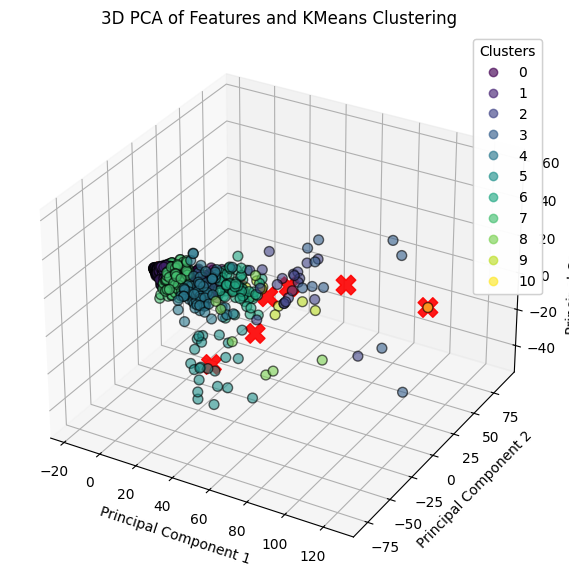

In [20]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# 假设 `data` 是我们之前从音频文件中提取的特征数据
# 数据标准化
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# PCA 降维到 3D
pca = PCA(n_components=3)
data_pca_3d = pca.fit_transform(data_scaled)

# KMeans 聚类
kmeans = KMeans(n_clusters=11, random_state=42, n_init=10)
labels = kmeans.fit_predict(data_pca_3d)

# 可视化 PCA 降维后的数据和 KMeans 聚类结果
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(data_pca_3d[:, 0], data_pca_3d[:, 1], data_pca_3d[:, 2], c=labels, cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.6)
ax.set_title('3D PCA of Features and KMeans Clustering')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# 标出聚类中心
centers = kmeans.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='red', s=200, alpha=0.9, marker='X')

# 添加图例
legend1 = ax.legend(*scatter.legend_elements(), loc="upper right", title="Clusters")
ax.add_artist(legend1)

plt.show()


Processing jazz genre:   0%|          | 0/100 [00:00<?, ?it/s]C:\Users\Akagi\AppData\Local\Temp\ipykernel_38616\2551936914.py:16: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(song_path, mono=True, duration=30)
C:\Users\Akagi\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Processing jazz genre: 100%|██████████| 100/100 [00:00<00:00, 774.64it/s]


Error processing ./genres/jazz\jazz.00054.wav: 


Processing rock genre: 100%|██████████| 100/100 [00:00<00:00, 737.96it/s]


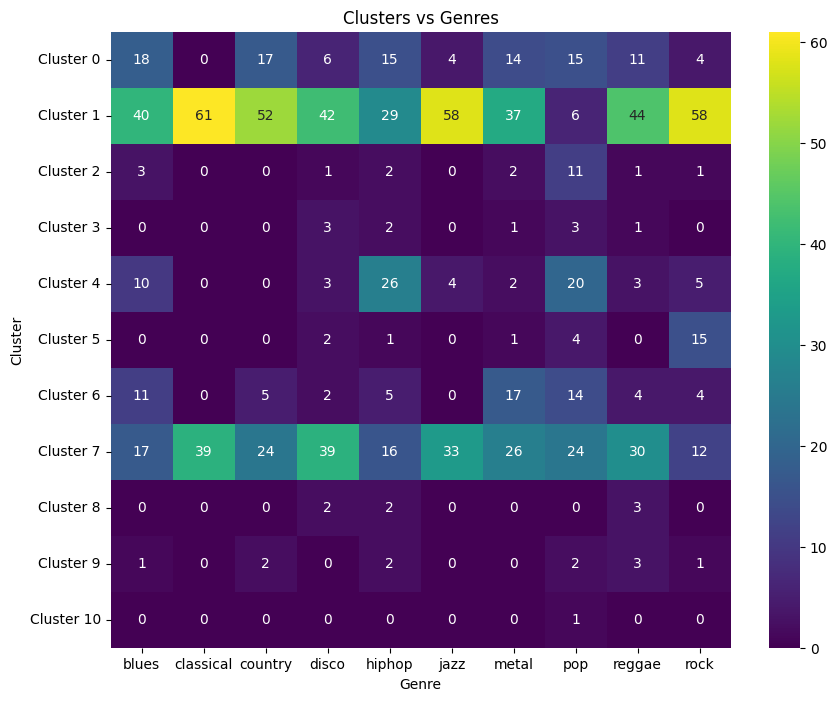

In [21]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

genres_labels = []

# genres_labels 是每首歌曲的原始流派标签列表
for genre in genres:
    genre_folder = f'./genres/{genre}'
    # 获取目录下的文件列表，并初始化一个tqdm进度条
    files = os.listdir(genre_folder)
    for filename in tqdm(files, desc=f'Processing {genre} genre'):
        song_path = os.path.join(genre_folder, filename)
        try:
            y, sr = librosa.load(song_path, mono=True, duration=30)            
            genres_labels.append(genre)
 
        except Exception as e:
            print(f"Error processing {song_path}: {e}")
            continue  # 发生异常时跳过当前文件，继续处理下一个文件


# 将流派标签编码为整数
le = LabelEncoder()
genres_encoded = le.fit_transform(genres_labels)

# 计算混淆矩阵
num_clusters = len(set(labels))  # 这里的 labels 是 KMeans 聚类的结果
num_genres = len(le.classes_)
conf_matrix = np.zeros((num_clusters, num_genres))

for i, cluster in enumerate(labels):
    conf_matrix[cluster, genres_encoded[i]] += 1

# 绘制热图
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt=".0f", cmap='viridis',
            xticklabels=le.classes_, yticklabels=['Cluster {}'.format(i) for i in range(num_clusters)])
plt.title('Clusters vs Genres')
plt.xlabel('Genre')
plt.ylabel('Cluster')
plt.show()
